In [1]:
from process_bank_churn import preprocess_data, preprocess_new_data

In [2]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [4]:
X_train, y_train, X_val, y_val, input_cols, scaler, encoder = preprocess_data(df, scale_numeric=False)

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [6]:
train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
val_auc = roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])
print("Train ROC AUC:", train_auc)
print("Validation ROC AUC:", val_auc)

Train ROC AUC: 1.0
Validation ROC AUC: 0.7560459956321718


Tree depth: 28


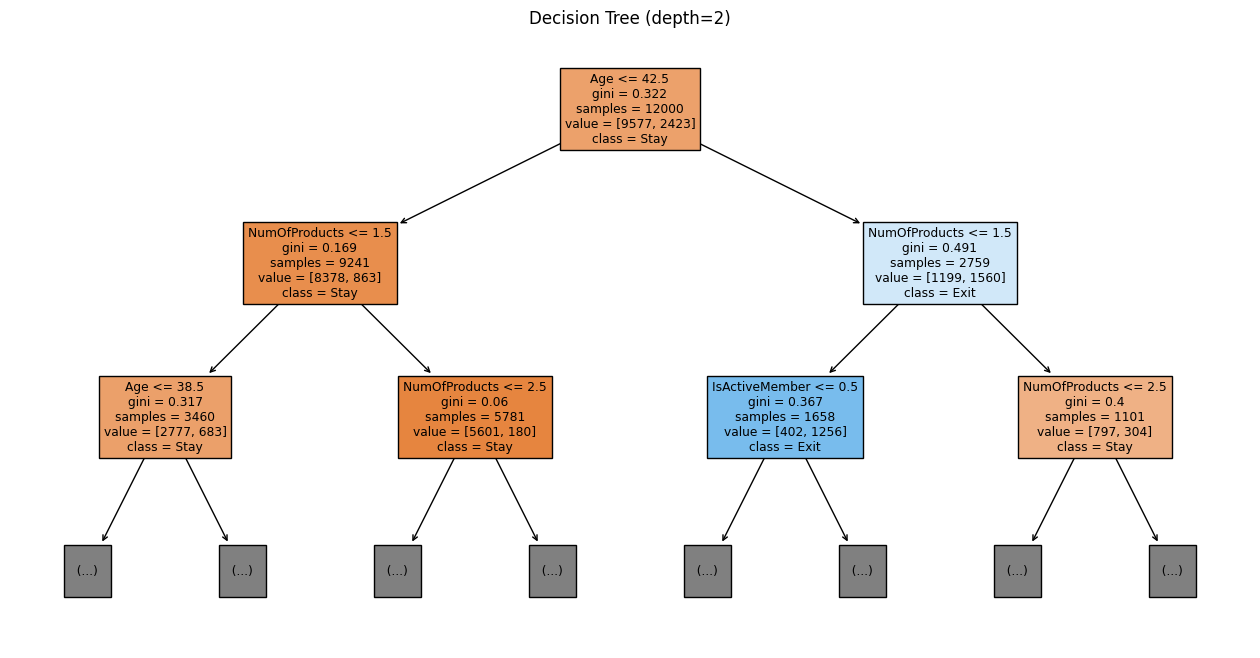

In [7]:
print("Tree depth:", clf.get_depth())

plt.figure(figsize=(16, 8))
plot_tree(clf, feature_names=input_cols, class_names=["Stay", "Exit"], filled=True, max_depth=2)
plt.title("Decision Tree (depth=2)")
plt.show()

In [8]:
importance_df = pd.DataFrame({
    "feature": input_cols,
    "importance": clf.feature_importances_
}).sort_values(by="importance", ascending=False)

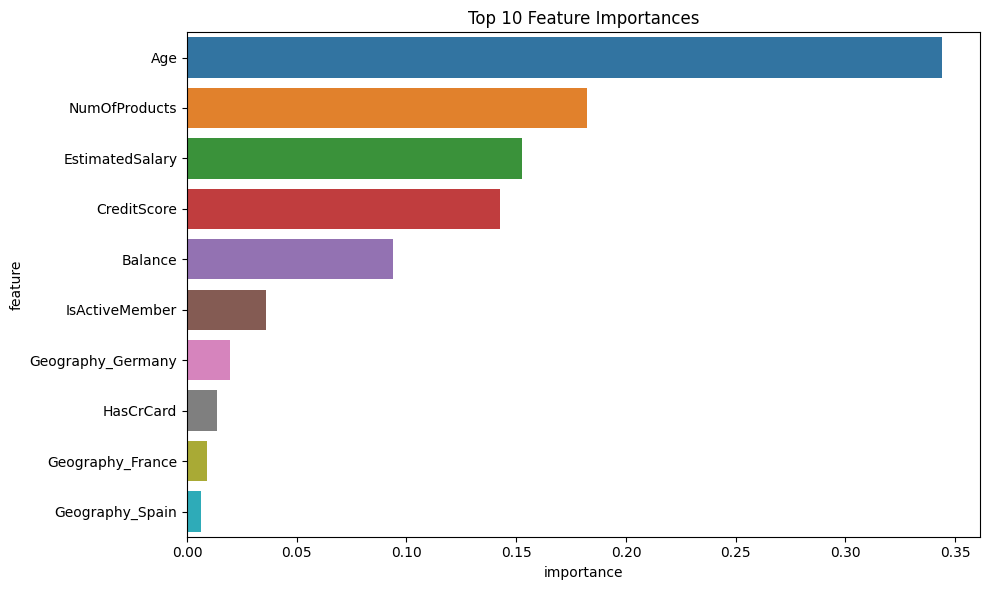

,feature,importance
1,Age,0.344118
3,NumOfProducts,0.182204
6,EstimatedSalary,0.152746
0,CreditScore,0.142529
2,Balance,0.093860
5,IsActiveMember,0.035922
8,Geography_Germany,0.019801
4,HasCrCard,0.013592
7,Geography_France,0.009006
9,Geography_Spain,0.006221


In [9]:
top_10 = importance_df.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=top_10)
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()

top_10

In [10]:
best_model = None
best_auc = 0
best_params = {}

for depth in [3, 5, 6, 7, 10, 15]:
    for leaves in [10, 20, 30, 40, 50, 100]:
        clf = DecisionTreeClassifier(max_depth=depth, max_leaf_nodes=leaves, random_state=42)
        clf.fit(X_train, y_train)
        val_probs = clf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, val_probs)

        if auc > best_auc:
            best_auc = auc
            best_model = clf
            best_params = {"max_depth": depth, "max_leaf_nodes": leaves}

print("Best parameters:", best_params)
print("Validation ROC AUC of the best model:", best_auc)

Найкращі параметри моделі: {'max_depth': 6, 'max_leaf_nodes': 40}
Validation ROC AUC найкращої моделі: 0.9152836439784117


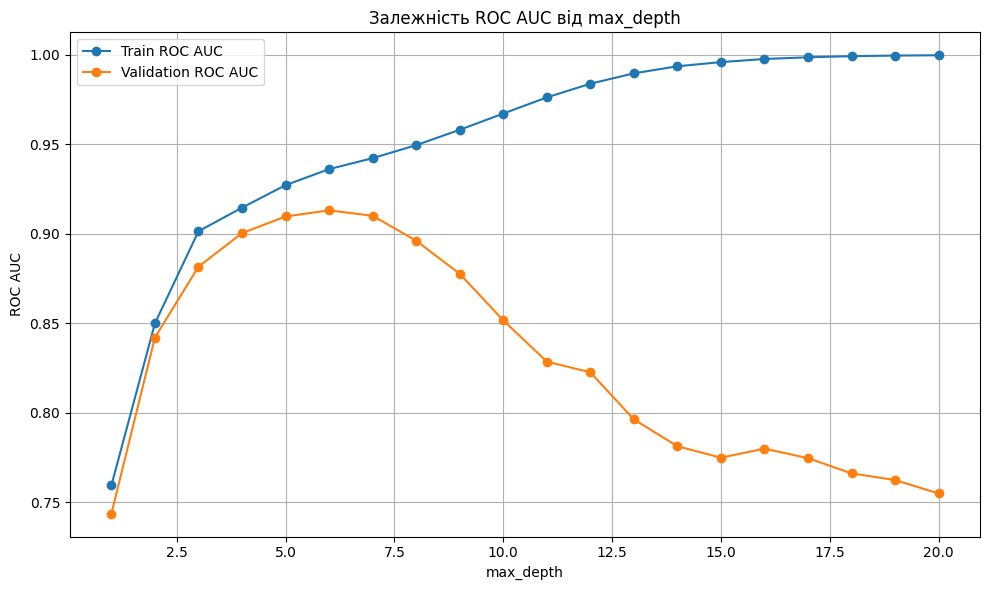

In [11]:
train_aucs = []
val_aucs = []
depth_range = range(1, 21)

for d in depth_range:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(X_train, y_train)
    train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    val_auc = roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])
    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

plt.figure(figsize=(10, 6))
plt.plot(depth_range, train_aucs, label="Train ROC AUC", marker='o')
plt.plot(depth_range, val_aucs, label="Validation ROC AUC", marker='o')
plt.xlabel("max_depth")
plt.ylabel("ROC AUC")
plt.title("Dependence of ROC AUC on max_depth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
X_test = preprocess_new_data(test_df, input_cols, encoder, scaler)
test_preds = best_model.predict_proba(X_test)[:, 1]

In [41]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "Exited": test_preds
})

In [42]:
submission.to_csv("submission.csv", index=False)